# Wine  Quality Prediction: Multiple Classifiers 
##### The goal of this project is to find the chemical component that affect wine quality
##### Wine quality dataset on Kaggle: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

### 1. Exploratory data analysis 

In [79]:
# installing seaborn library on Jupyterlite
%pip install seaborn

In [80]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# import packages from sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [81]:
# data loading process
data = pd.read_csv("wine_quality_data.csv")
data.head(5)

# all predicter variables are numeric

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Note:**
- **fixed acidity**: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)

- **volatile acidity**: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste

- **citric acid**: found in small quantities, citric acid can add 'freshness' and flavor to wines

- **residual sugar**: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet

- **chlorides**: the amount of salt in the wine
- **free sulfur dioxide (free SO2)**: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine -- SO₂(g) + H₂O(l) ⇌ H⁺(aq) + HSO₃⁻(aq) and 2HSO₃⁻(aq) ⇌ S₂O₅²⁻(aq) + H₂O(l)

 - **total sulfur dioxide (total S)**: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine

 - **density**: the density of water is close to that of water depending on the percent alcohol and sugar content

 - **pH**: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale

 - **sulphates**: a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant

From the data, We can imply the following assumption based on knowledge:

 - Bound SO2 = Total SO2 - free SO2
   
 - Total SO2 will have positive relationship with sulphates (but yeast already produce some, so there is a baseline value)


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [83]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [84]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### 1.1 Data Visualization 

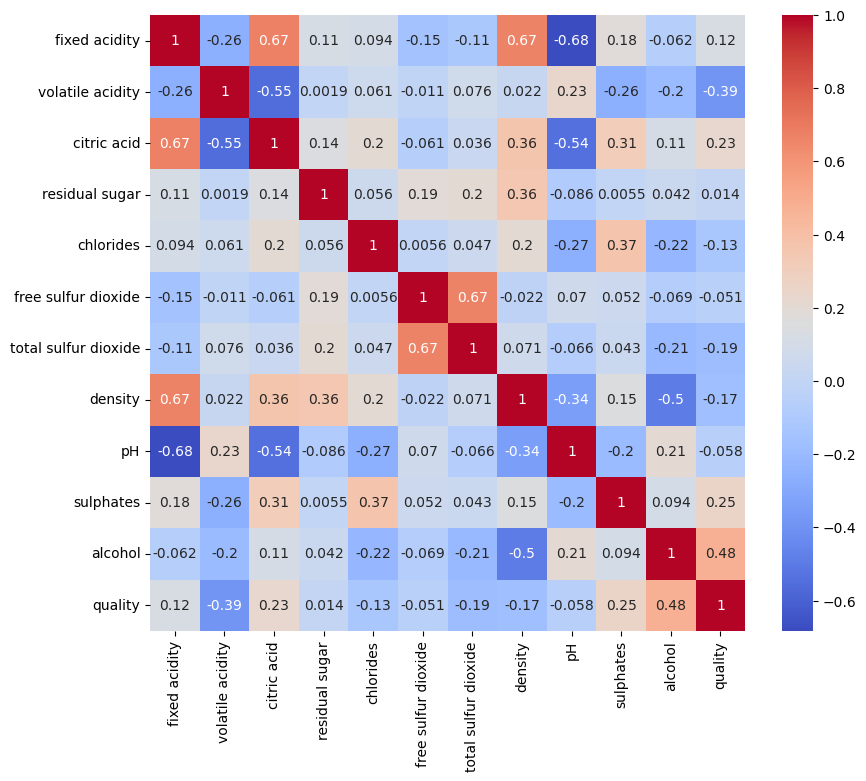

In [85]:
# broader view of relationships
correlation_matrix = data.corr()
plt.figure(figsize = (9.6, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

**Note:**

(1) Sulfur Dioxide: Total sulfur dioxide shows a strong positive correlation (0.67) with free sulfur dioxide. This is expected, as the total amount is the sum of the free and bound forms.

(2) Acidity and pH: pH has a strong negative correlation (-0.68) with fixed acidity. This makes chemical sense, as higher acidity (more H+ ions) results in a lower pH value.

(3) Citric Acid and pH: Citric acid displays a moderate negative correlation (-0.54) with pH, indicating that higher concentrations of citric acid are associated with lower pH levels.

(4) Alcohol and Density: Alcohol has a moderate negative correlation (-0.50 ) with density. This is because alcohol (≈0.79 g/cm³) is less dense than water (≈1.0 g/cm³), so a higher alcohol content will lower the wine's overall density.

(5) Total Sulfur Dioxide and pH: Total sulfur dioxide shows a very weak negative correlation (-0.07) with pH. While SO₂ is acidic, its effect on the overall pH is minimal. This is likely because the wine's pH is dominated by the much larger concentrations of other acids (like fixed acidity), which create a buffered solution that resists small changes.

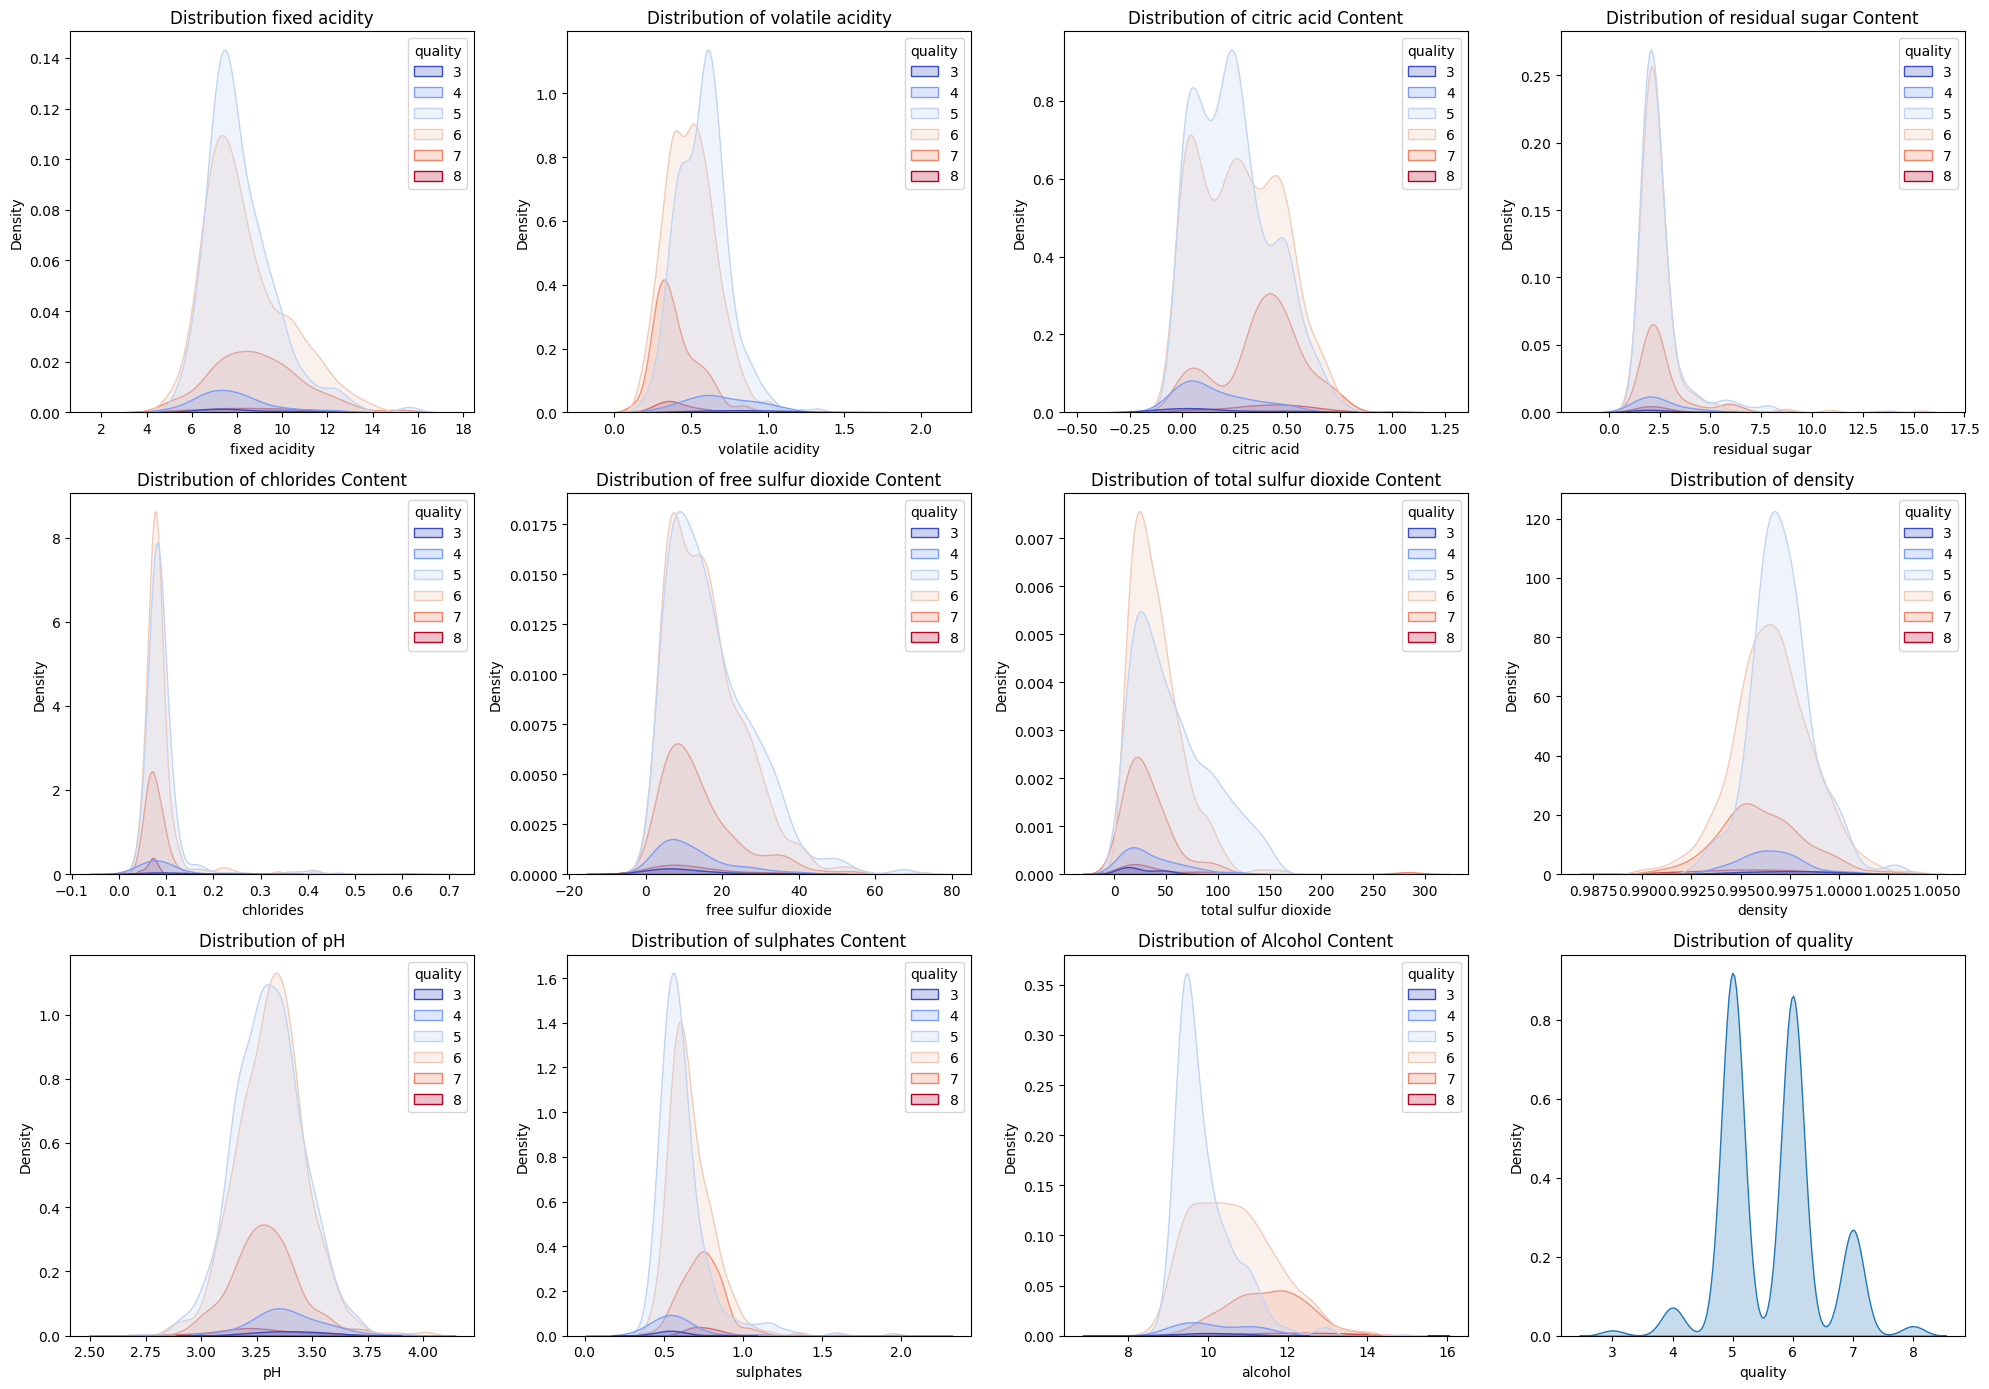

In [86]:
# use count plot for categorial variables
fig, axes = plt.subplots(3, 4, figsize = (20, 14))
custom_palette = "coolwarm"

sns.kdeplot(data = data, x = 'fixed acidity', hue = 'quality', fill=True, palette=custom_palette, ax = axes[0,0])
axes[0,0].set_title('Distribution fixed acidity')

sns.kdeplot(data = data, x = 'volatile acidity', hue = 'quality', fill=True, palette=custom_palette, ax = axes[0,1])
axes[0,1].set_title('Distribution of volatile acidity')

sns.kdeplot(data = data, x = 'citric acid', hue = 'quality', fill=True, palette = custom_palette, ax = axes[0,2])
axes[0,2].set_title('Distribution of citric acid Content')

sns.kdeplot(data = data, x = 'residual sugar', hue = 'quality', fill=True, palette=custom_palette, ax = axes[0,3])
axes[0,3].set_title('Distribution of residual sugar Content')

sns.kdeplot(data = data, x = 'chlorides', hue = 'quality', fill=True, palette=custom_palette, ax = axes[1,0])
axes[1,0].set_title('Distribution of chlorides Content')

sns.kdeplot(data = data, x = 'free sulfur dioxide', hue = 'quality', fill=True, palette=custom_palette, ax = axes[1,1])
axes[1,1].set_title('Distribution of free sulfur dioxide Content')

sns.kdeplot(data = data, x = 'total sulfur dioxide', hue = 'quality', fill=True, palette=custom_palette, ax = axes[1,2])
axes[1,2].set_title('Distribution of total sulfur dioxide Content')

sns.kdeplot(data = data, x = 'density', hue = 'quality', fill=True, palette=custom_palette, ax = axes[1,3])
axes[1,3].set_title('Distribution of density')

sns.kdeplot(data = data, x = 'pH', hue = 'quality', fill=True, palette=custom_palette, ax = axes[2,0])
axes[2,0].set_title('Distribution of pH')

sns.kdeplot(data = data, x = 'sulphates', hue = 'quality', fill=True, palette=custom_palette, ax = axes[2,1])
axes[2,1].set_title('Distribution of sulphates Content')

sns.kdeplot(data = data, x = 'alcohol', hue = 'quality', fill=True, palette=custom_palette, ax = axes[2,2])
axes[2,2].set_title('Distribution of Alcohol Content')

sns.kdeplot(data = data, x = 'quality', fill=True, ax = axes[2,3])
axes[2,3].set_title('Distribution of quality')

plt.tight_layout()
plt.show()

**Note:**

(1) The KDE plots show that many key predictor variables, like alcohol, have approximately bell-shaped distributions for each quality category. This visual evidence lends support to using the Gaussian Naive Bayes (GaussianNB) model, which assumes features follow a normal (Gaussian) distribution within each class.

(2) Good Predictors:
- Volatile Acidity: A clear leftward shift in the peaks indicates that lower volatile acidity is strongly associated with higher quality wines.
- Citric Acid: The distribution peaks for citric acid shift to the right, suggesting that higher levels are a feature of better wines.
- Sulphates: Similarly, sulphates display a rightward shift in distribution, linking higher content to higher quality.
- Alcohol: Alcohol exhibits the most pronounced rightward shift in its distribution peaks. The clear separation shows that higher quality wines consistently have a higher alcohol content.

### 1.2 EDA Summary

- Predictive Features: The most promising predictors for wine quality appear to be alcohol, volatile acidity, sulphates, and citric acid, all of which show clear trends when plotted against the quality score.

- Class Imbalance: The target variable, quality, is imbalanced. The 'medium' quality class represents the vast majority of the samples, which could bias a model's performance.

- Feature Skewness: Several features, most notably residual sugar, chlorides, and free sulfur dioxide, are heavily right-skewed and not normally distributed.

- Multicollinearity: Strong correlations exist between certain features, such as the negative correlation between fixed acidity and pH, and the positive correlation between free and total sulfur dioxide.

### 2. Feature Engineering and data preparation

#### Since the result "quality" has strong class imbalances, we need to categorize quality to reduce class imbalance 

In [87]:
# perform transfromation: seperate the quality data into categories

# 1. Define the number of quantiles (e.g., 3 for low, medium, high) and the labels.
q_bins = 3
q_labels = ['low', 'medium', 'high']

# 2. Use pd.qcut to create the 'quality_category' column.
# The duplicates='drop' argument is added to handle cases where bin edges are not unique.
data['quality_category'] = pd.qcut(data['quality'],
                                   q=q_bins,
                                   labels=q_labels,
                                   duplicates='drop')

# 3. (Optional) Check the new, more balanced distribution of categories.
print("New distribution after quantile binning:")
print(data['quality_category'].value_counts())

New distribution after quantile binning:
quality_category
low       744
medium    638
high      217
Name: count, dtype: int64


### 2.1 Creating reusable functions for model evaluation pipeline 

##### (1) The step will build and evaluate several standard classification models using their default parameters. 
##### (2) The objective is to identify the top-performing algorithm(s) for further optimization.
##### (3) Reusable pipeline function is created (run_classification_pipeline) to automate this process. 
##### (4) The pipeline will handle data scaling and training for each classifier to ensure a fair comparison.
##### (5) Seperate functions are built for train-test-split and train-validation-test -split

#### **Create functions for simultaneous evaluation of muiltiple baseline models**

#### **(1) Function for train-validation-test split**

**Preventing data leakage - The train-validation-test-split:**

To ensure a robust and unbiased evaluation of our models, the data is split into three distinct sets:

- Training Set (60%): Used exclusively to train the models.

- Validation Set (20%): Used for all intermediate decisions, such as comparing baseline models and tuning hyperparameters. This set acts as a proxy for unseen data during the development phase.

- Test Set (20%): Held out until the very end. It is used only once to evaluate the final, tuned model, providing an unbiased estimate of its real-world performance.

This three-way split prevents "data leakage," where information from the test set might indirectly influence model selection, leading to overly optimistic performance metrics.

In [88]:
# this automatic modeling and evaluation function will 
# (1) take X and y and split into X_train, X_val, X_test y_train, y_val, y_test for modeling train_test_split(X, y, testsize, random_state)
# (2) define catrgorial and numerical transformer
# (3) pipeline building: preprocesser, list of models
# (3) take a list of model for iteration
# (4) return model evaluation metrics: Accuracy, Precision, Recall, F-score 

def run_classification_pipeline_train_val_test(X_train, X_val, y_train, y_val, cat_columns, num_columns):

    # define classifiers using a dictionary
    classifiers = {
                   'Logistic Regression':LogisticRegression(max_iter=1000, random_state=42), 
                   'Decision Tree': DecisionTreeClassifier(random_state=42), 
                   'Random Forest': RandomForestClassifier(random_state=42),
                   'Gaussian Naive Bayes': GaussianNB(),
                   'k-Neighbor': KNeighborsClassifier(),
                   'Gradient Boost': GradientBoostingClassifier(random_state=42),
                   'Support Vector': SVC(random_state=42, probability = True)
                  }  

    # dictionary to store results
    evaluation_results = {}
    
    # define categorial and numeriacal variables
    categorial_features = cat_columns
    numerical_features = num_columns

    # define preprocessing steps for categorial and numeriacal variables
    numeric_transformer = Pipeline(steps = [('scalar', StandardScaler())])
    categorial_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
    preprocesser = ColumnTransformer(transformers = [('num', numeric_transformer, numerical_features), ('cat', categorial_transformer, categorial_features)])

    # building models with different classifier
    for model_name, classifier in classifiers.items():
        pipeline = Pipeline(steps = [('preprocesser', preprocesser),('model', classifier)]) 
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)

        # model evaluation parameters
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='weighted')
        recall = recall_score(y_val, y_pred, average='weighted')
        f1_result = f1_score(y_val, y_pred, average='weighted')

        # a dictionary storing evaluation result of each classifier
        evaluation_results[model_name]= {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, "F1 score": f1_result}
        
    # for a nicer output, convert the dictionary to a pandas DataFrame
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
    print("Model Evaluation Results:")
    print(results_df)
    print("-"*70)
    
    return evaluation_results

#### **(2) Function for train-test split**

In [89]:
# this automatic modeling and evaluation function will 
# (1) take X and y and split into X_train, X_test y_train, y_test for modeling train_test_split(X, y, testsize, random_state)
# (2) define catrgorial and numerical transformer
# (3) pipeline building: preprocesser, list of models
# (3) take a list of model for iteration
# (4) return model evaluation metrics: Accuracy, Precision, Recall, F-score 

def run_classification_pipeline_train_test(X_train, X_test, y_train, y_test, cat_columns, num_columns):

    # define classifiers using a dictionary
    classifiers = {
                   'Logistic Regression':LogisticRegression(max_iter=1000, random_state=42), 
                   'Decision Tree': DecisionTreeClassifier(random_state=42), 
                   'Random Forest': RandomForestClassifier(random_state=42),
                   'Gaussian Naive Bayes': GaussianNB(),
                   'k-Neighbor': KNeighborsClassifier(),
                   'Gradient Boost': GradientBoostingClassifier(random_state=42),
                   'Support Vector': SVC(random_state=42, probability = True)
                  }  

    # dictionary to store results
    evaluation_results = {}
    
    # define categorial and numeriacal variables
    categorial_features = cat_columns
    numerical_features = num_columns

    # define preprocessing steps for categorial and numeriacal variables
    numeric_transformer = Pipeline(steps = [('scalar', StandardScaler())])
    categorial_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
    preprocesser = ColumnTransformer(transformers = [('num', numeric_transformer, numerical_features), ('cat', categorial_transformer, categorial_features)])

    # building models with different classifier
    for model_name, classifier in classifiers.items():
        pipeline = Pipeline(steps = [('preprocesser', preprocesser),('model', classifier)]) 
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # model evaluation parameters
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1_result = f1_score(y_test, y_pred, average='weighted')

        # a dictionary storing evaluation result of each classifier
        evaluation_results[model_name]= {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, "F1 score": f1_result}
        
    # for a nicer output, convert the dictionary to a pandas DataFrame
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
    print("Model Evaluation Results:")
    print(results_df)
    print("-"*70)
    
    return evaluation_results

### 2.2 Data preparation

This project uses a Train/Test split combined with k-fold Cross-Validation for model evaluation and selection. This method was chosen for the following reasons:

- Dataset Size: The wine quality dataset, with 1599 entries, is considered relatively small. For smaller datasets, cross-validation is the preferred technique because it makes more efficient use of the data.

- Robust Performance Estimate: Cross-validation provides a more reliable and stable measure of model performance than a single validation set. It mitigates the risk that the evaluation is skewed by a "lucky" or "unlucky" random split of the data by averaging performance across multiple validation folds.

- Unbiased Final Evaluation: This approach properly holds out a final test set that is used only once to evaluate the chosen champion model. This ensures a good, unbiased understanding of the model's expected performance on new, unseen data.

In [90]:
# prepare train and test dataset
y = data['quality_category']
X = data.drop(columns = ['quality', 'quality_category'], axis = 1)

In [91]:
# this procedure is for train-validation-test-split

# First, split into training and a temporary set (which will become validation + test)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Now, split the temporary set into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# train: 0.6, test: 0.2, validation: 0.2
# print("Training set shape:", X_train.shape)
# print("Validation set shape:", X_val.shape)
# print("Testing set shape:", X_test.shape)

In [92]:
# this procedure is for train--test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Testing set shape:", y_train.shape)
print("Testing set shape:", y_test.shape)

Training set shape: (1279, 11)
Testing set shape: (320, 11)
Testing set shape: (1279,)
Testing set shape: (320,)


### 2.3 Baseline Model Selection & Hyper-parameter tuning

#### **Examine baseline result**

In [93]:
# Run the pipeline and store the results
baseline_result = run_classification_pipeline_train_test(X_train, X_test, y_train, y_test, [], X.columns.to_list())

Model Evaluation Results:
                      Accuracy  Precision    Recall  F1 score
Logistic Regression   0.596875   0.588461  0.596875  0.589472
Decision Tree         0.690625   0.691235  0.690625  0.690916
Random Forest         0.750000   0.748793  0.750000  0.748340
Gaussian Naive Bayes  0.578125   0.594152  0.578125  0.584117
k-Neighbor            0.606250   0.606349  0.606250  0.605601
Gradient Boost        0.681250   0.676799  0.681250  0.677615
Support Vector        0.665625   0.662123  0.665625  0.658319
----------------------------------------------------------------------


Based on the baseline evaluation, Random Forest was the top-performing model with an F1-score of 0.748340, significantly outperforming the next-best model, Decision Tree, at 0.664. Given Random Forest's inherently more robust ensemble nature and its superior baseline performance, hyperparameter tuning is performed on this model to maximize its potential.

#### **Perform hyperparameter tuning uisng GridSearchCV**

In [94]:
# 1. Create a pipeline with the scaler and the classifier
# This ensures the data is scaled correctly within each cross-validation fold
pipeline = Pipeline(steps=[('scaler', StandardScaler()),('classifier', RandomForestClassifier(random_state=42))])

# 2. Define a grid of hyperparameters to search
# These are common parameters to tune for a Random Forest.
# The prefix 'classifier__' targets the parameters of the model step in the pipeline.
param_grid = {
                'classifier__n_estimators': [100, 200],        # Number of trees in the forest
                'classifier__max_depth': [10, 20, None],       # Maximum depth of the trees
                'classifier__min_samples_split': [2, 5],       # Minimum samples required to split a node
                'classifier__min_samples_leaf': [1, 2]         # Minimum samples required at a leaf node
             }

# 3. Create the GridSearchCV object
# cv=5 means 5-fold cross-validation will be used.
# n_jobs=-1 uses all available CPU cores to speed up computation.
# scoring='f1_weighted': A good metric for classification with imbalanced classes
grid_search = GridSearchCV(estimator = pipeline, 
                           param_grid = param_grid, 
                           cv = 5, 
                           n_jobs = -1, 
                           scoring = 'f1_weighted',
                           verbose = 1)

# 4. Fit the grid search to the training data
print("Starting hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)

# 5. Print the best parameters and the corresponding score
print("\n--- Tuning Complete ---")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1-score: ", grid_search.best_score_)

Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

--- Tuning Complete ---
Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation F1-score:  0.6873728015175297


#### **Visualize evaluation result with confusion matrix**

--- Final Model Classification Report ---
              precision    recall  f1-score   support

        high       0.68      0.53      0.60        43
         low       0.80      0.83      0.82       149
      medium       0.70      0.72      0.71       128

    accuracy                           0.75       320
   macro avg       0.73      0.70      0.71       320
weighted avg       0.74      0.75      0.74       320

--- Confusion Matrix ---


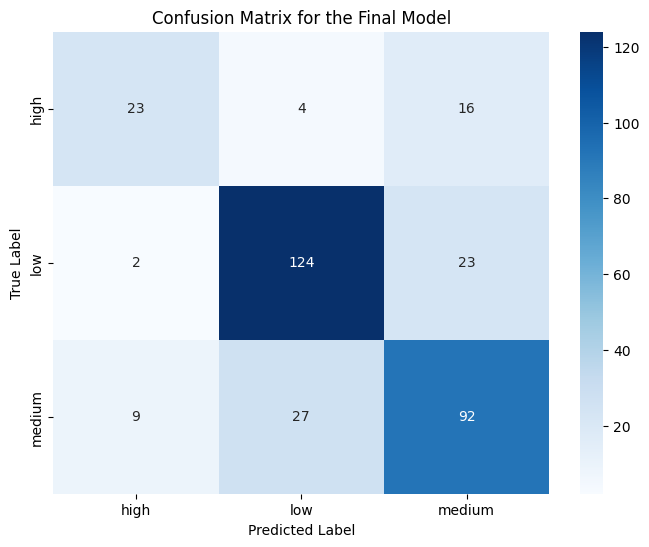

In [95]:
# 1. Get the best model from your grid search
# The .best_estimator_ attribute already contains the fully trained model with the best parameters.
final_model = grid_search.best_estimator_

# 2. Make predictions on the test set
# This is the first and only time we use the test set for evaluation.
y_test_pred = final_model.predict(X_test)

# 3. Print the classification report
# This gives a detailed breakdown of precision, recall, and f1-score for each class.
print("--- Final Model Classification Report ---")
print(classification_report(y_test, y_test_pred))

# 4. Create and visualize a confusion matrix
# This helps you see exactly where the model is making correct and incorrect predictions.
print("--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for the Final Model')
plt.show()

#### **Visualize evaluation result with ROC curve**

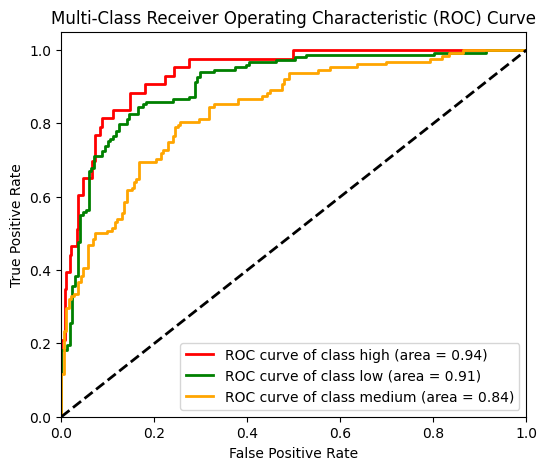

In [96]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- Multi-Class ROC Curve ---

# 1. Binarize the true labels in a one-vs-rest fashion
# This converts your 'low', 'medium', 'high' labels into a numerical format
y_test_binarized = label_binarize(y_test, classes=final_model.classes_)
n_classes = y_test_binarized.shape[1]

# 2. Get the predicted probability scores for each class
# This is crucial for plotting the ROC curve
y_score = final_model.predict_proba(X_test)

# Dictionaries to hold the ROC curve data for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# 3. Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot all ROC curves on the same graph
plt.figure(figsize=(6, 5))

colors = ['Red', 'Green', 'Orange'] 

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(final_model.classes_[i], roc_auc[i]))

# Plot the "chance" line (a model with no skill)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 3. Store the model for further uses

#### **Use the model with a new dataset**

In [105]:
def predict_wine_quality():
    """
    This function prompts the user to enter wine characteristics,
    and then uses the trained model to predict the quality category.
    """
    print("Please enter the following wine characteristics:")

    # Define the input features and their data types
    features = {
        'fixed acidity': float,
        'volatile acidity': float,
        'citric acid': float,
        'residual sugar': float,
        'chlorides': float,
        'free sulfur dioxide': float,
        'total sulfur dioxide': float,
        'density': float,
        'pH': float,
        'sulphates': float,
        'alcohol': float
    }

    # Collect user input
    user_input = {}
    for feature, dtype in features.items():
        while True:
            try:
                value = dtype(input(f" - {feature.replace('_', ' ').title()}: "))
                user_input[feature] = value
                break
            except ValueError:
                print(f"Invalid input. Please enter a numerical value for {feature}.")

    # Convert the user input into a DataFrame
    input_df = pd.DataFrame([user_input])

    # Use the final_model (the best estimator from GridSearchCV) to predict
    prediction = final_model.predict(input_df)

    # Print the prediction
    print("\n" + "="*30)
    print(f"The predicted wine quality is: {prediction[0].upper()}")
    print("="*30)

In [106]:
predict_wine_quality()

Please enter the following wine characteristics:


 - Fixed Acidity:  3
 - Volatile Acidity:  3
 - Citric Acid:  3
 - Residual Sugar:  3
 - Chlorides:  3
 - Free Sulfur Dioxide:  3
 - Total Sulfur Dioxide:  


Invalid input. Please enter a numerical value for total sulfur dioxide.


 - Total Sulfur Dioxide:  3
 - Density:  3
 - Ph:  3
 - Sulphates:  3
 - Alcohol:  3



The predicted wine quality is: LOW


### 4. Conclusion

The project sucessfully developed and evaluate multiple machine learning models to predict the quality of red wine.

Key Findings from Data Analysis

- Top Predictors: The most influential features for determining wine quality were identified as alcohol, volatile acidity, sulphates, and citric acid. These features showed clear and distinct trends when compared across different quality scores.

- Class Imbalance: A significant challenge was the imbalanced nature of the "quality" variable, with most wines falling into the 'medium' category. To address this, the "quality" score was categorized into three balanced groups: 'low', 'medium', and 'high'.

- Model Performance and Selection
Baseline Champion: The Random Forest classifier emerged as the top-performing model in the baseline evaluation, achieving an impressive F1-score of 0.748. This outperformed all other models, including the Decision Tree, which was the next best at 0.691.

- Hyperparameter Tuning: The Random Forest model was further optimized using GridSearchCV, which identified the best combination of parameters to be a max_depth of 20, min_samples_leaf of 1, min_samples_split of 5, and n_estimators of 200.

- Final Evaluation: After tuning, the final model achieved a weighted average F1-score of 0.74 on the held-out test data. The model demonstrated strong predictive power, especially in distinguishing 'low' quality wines with high precision and recall.